# **Image Super-Resolution with SRCNN (Deep Learning Model)**

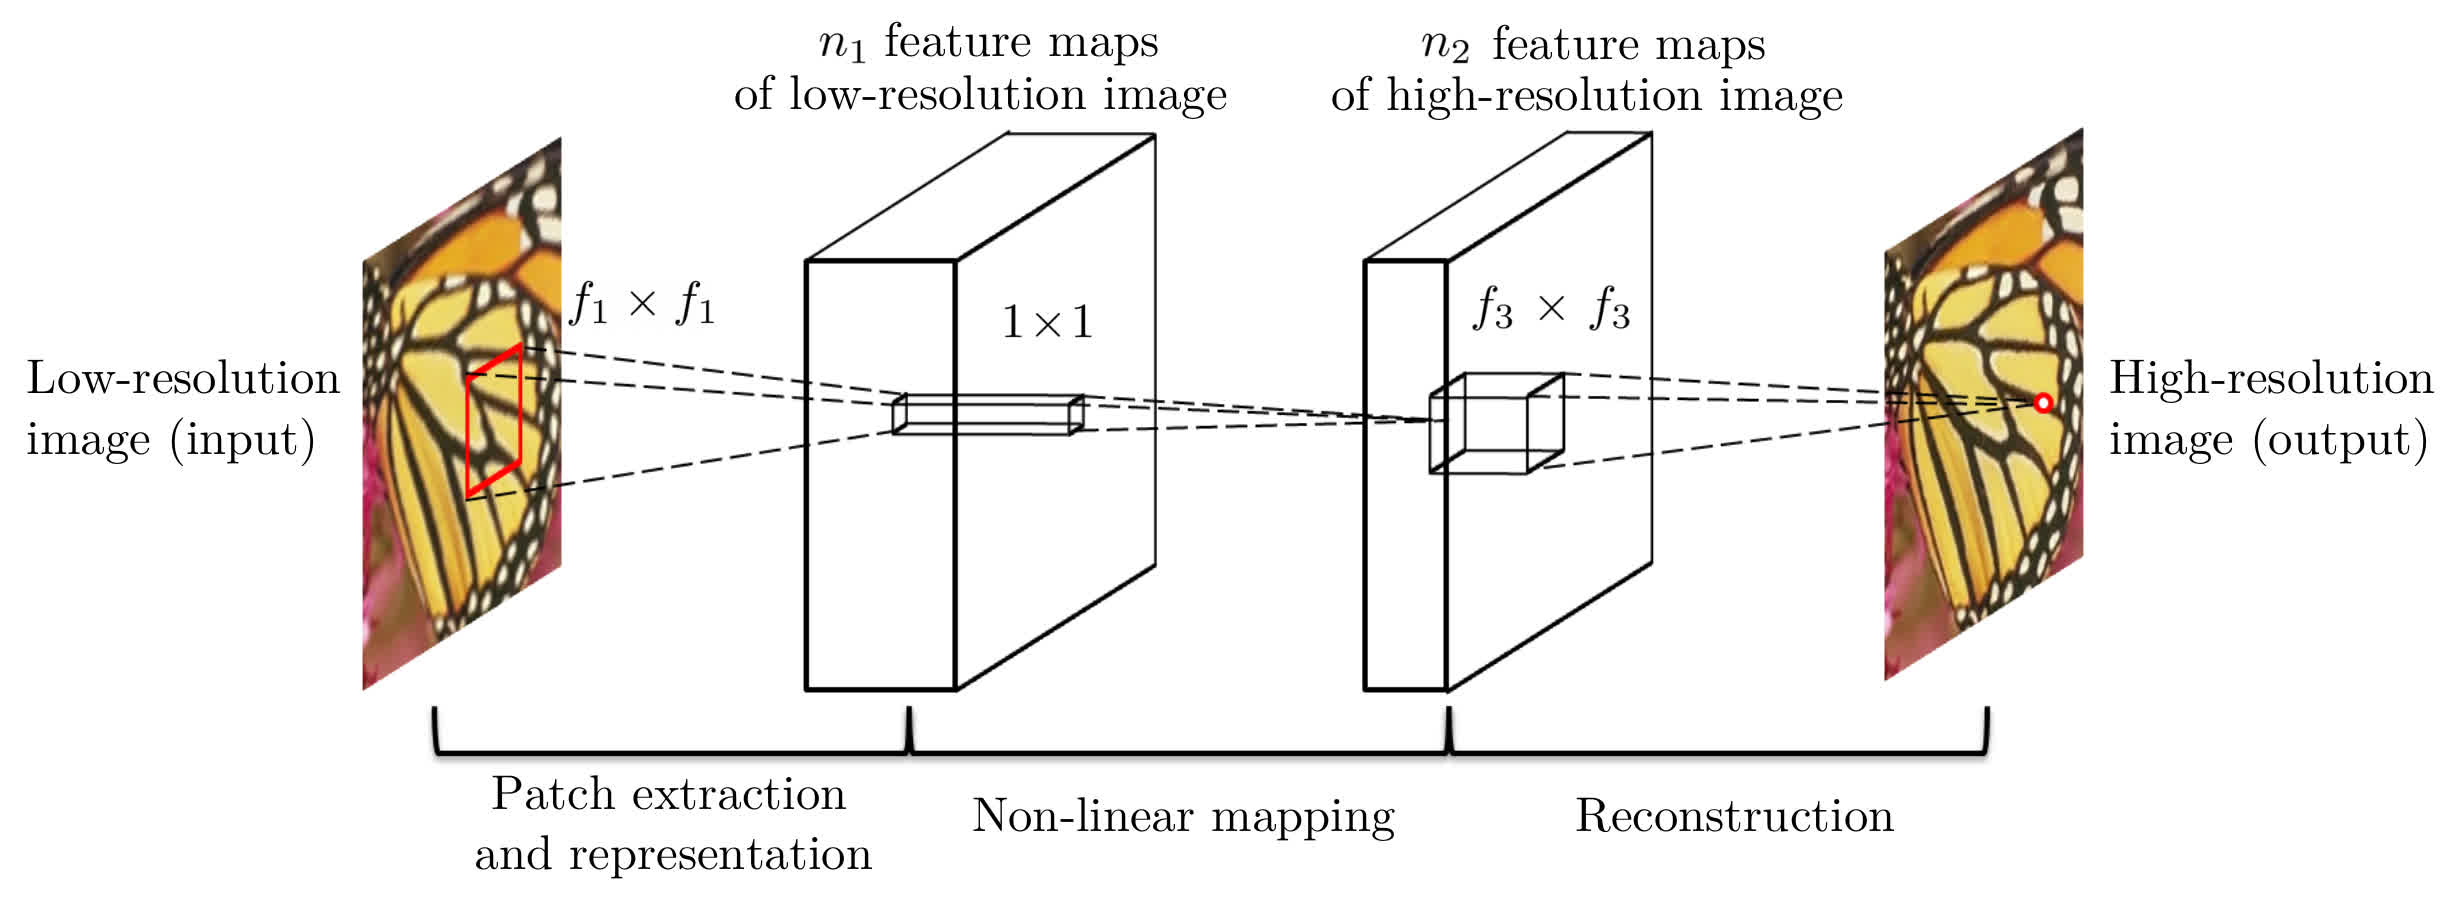

## Clone Repository for Loading Dataset

In [ ]:
!git clone https://github.com/Magauiya/Extended_SURE.git

## Import Library

In [ ]:
from os import listdir, makedirs
from os.path import join

from PIL import Image

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

from torchvision import transforms
import torchvision.transforms.functional as TF

## Create Custom Dataloader

In [ ]:
class MyDataLoader(Dataset) :
  def __init__(self, dataroot, is_train, crop_size) :
    # Inheritance
    super(MyDataLoader, self).__init__()

    # Create Data Augmentation Instance
    if is_train :
      self.transforms = transforms.Compose([transforms.RandomCrop((crop_size, crop_size)),
                                            transforms.RandomHorizontalFlip(0.5),
                                            transforms.RandomVerticalFlip(0.5),
                                            transforms.ToTensor()])
    else :
       self.transforms = transforms.Compose([transforms.CenterCrop((crop_size, crop_size)),
                                             transforms.ToTensor()])

    # Initialize Variable
    self.img_path_list = [join(dataroot, img_name) for img_name in listdir(dataroot) if img_name.split(".")[-1] in ["jpg", "png"]]

  def __getitem__(self, index) :
    img_path = self.img_path_list[index]

    img = Image.open(img_path).convert("RGB")
    img = self.transforms(img)

    return {"img":img}

  def __len__(self) :
    return len(self.img_path_list)

## Create SRCNN Model Class

In [ ]:
class SRCNN(nn.Module) :
  def __init__(self, in_channels, hid_channels, num_layers) :
    super().__init__()

    self.conv_in = nn.Conv2d(in_channels, hid_channels, kernel_size=3, stride=1, padding=1)
    self.conv_feat = nn.Sequential(*[nn.Sequential(nn.Conv2d(hid_channels, hid_channels, kernel_size=3, stride=1, padding=1),
                                                   nn.ReLU(inplace=True)) for _ in range(num_layers)])
    self.conv_out = nn.Conv2d(hid_channels, in_channels, kernel_size=3, stride=1, padding=1)

  def forward(self, x) :
    x = self.conv_in(x)
    x = self.conv_feat(x)
    x = self.conv_out(x)

    return x

## Set Hyperparameters

In [ ]:
opt = {"seed":42, "in_channels":3, "hid_channels":128, "num_layers":12, "crop_size":128, "scale":2, "lr":1e-4, "batch_size":8, "epochs":20, "cuda":torch.cuda.is_available()}

## Fix Seed

In [ ]:
import random
import numpy as np

In [ ]:
def fix_seed(seed) :
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

## Summarize SR Model

In [ ]:
from torchsummary import summary

In [ ]:
fix_seed(opt["seed"])

In [ ]:
model = SRCNN(opt["in_channels"], opt["hid_channels"], opt["num_layers"])

In [ ]:
if opt["cuda"] :
  model = model.cuda()

In [ ]:
summary(model, (3, 256, 256))

## Import Torchmetrics Library for Qunatitative Assessment

In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

In [ ]:
psnr, ssim = PeakSignalNoiseRatio(), StructuralSimilarityIndexMeasure()

In [ ]:
if opt["cuda"] :
  psnr, ssim = psnr.cuda(), ssim.cuda()

## Create AverageMeter Class

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
loss_train, psnr_train, ssim_train = AverageMeter(), AverageMeter(), AverageMeter()
loss_test, psnr_test, ssim_test = AverageMeter(), AverageMeter(), AverageMeter()

In [ ]:
loss_list_train, psnr_list_train, ssim_list_train = [], [], []
loss_list_test, psnr_list_test, ssim_list_test = [], [], []

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=opt["lr"])

In [ ]:
criterion = nn.L1Loss()

## Create DataLoader Instance

In [ ]:
fix_seed(opt["seed"])

In [ ]:
train_dataloader = DataLoader(MyDataLoader("/content/Extended_SURE/Dataset/CBSD432", True, opt["crop_size"]), batch_size=opt["batch_size"], shuffle=True, drop_last=True)
test_dataloader = DataLoader(MyDataLoader("/content/Extended_SURE/Dataset/testset/CBSD68", False, 256), batch_size=opt["batch_size"], shuffle=False, drop_last=False)

## Train DnCNN Model

In [ ]:
from tqdm import tqdm

In [ ]:
def generate_lr(hr, scale) :
  lr = F.interpolate(hr, scale_factor=1/scale, mode="bicubic")
  lr = F.interpolate(lr, scale_factor=scale, mode="bicubic")
  return lr

In [ ]:
for epoch in range(1, opt["epochs"]+1) :
    train_bar = tqdm(train_dataloader)
    loss_train.reset(), psnr_train.reset(), ssim_train.reset()

    for data in train_bar :
      img = data["img"]
      if opt["cuda"] :
        img = img.cuda()

      hr = img
      lr = generate_lr(hr, opt["scale"])

      model.train()
      optimizer.zero_grad()
      pred = model(lr)
      loss = criterion(pred, hr)
      loss.backward()
      optimizer.step()

      loss_train.update(loss.item(), opt["batch_size"])
      psnr_train.update(psnr(pred, hr).item(), opt["batch_size"])
      ssim_train.update(ssim(pred, hr).item(), opt["batch_size"])

      train_bar.set_description(desc=f"[{epoch}/{opt['epochs']}] [Train] < Loss:{loss_train.avg:.4f} | PSNR:{psnr_train.avg:.4f} | SSIM:{ssim_train.avg:.4f} >")

    loss_list_train.append(loss_train.avg)
    psnr_list_train.append(psnr_train.avg)
    ssim_list_train.append(ssim_train.avg)

    test_bar = tqdm(test_dataloader)
    loss_test.reset(), psnr_test.reset(), ssim_test.reset()

    for data in test_bar :
      img = data["img"]
      if opt["cuda"] :
        img = img.cuda()

      hr = img
      lr = generate_lr(hr, opt["scale"])

      model.eval()
      with torch.no_grad() :
        pred = model(lr).clamp(0,1)
        loss = criterion(pred, hr)

        loss_test.update(loss.item(), opt["batch_size"])
        psnr_test.update(psnr(pred, hr).item(), opt["batch_size"])
        ssim_test.update(ssim(pred, hr).item(), opt["batch_size"])

        test_bar.set_description(desc=f"[{epoch}/{opt['epochs']}] [Test] < Loss:{loss_test.avg:.4} | PSNR:{psnr_test.avg:.4f} | SSIM:{ssim_test.avg:.4f} >")

    sample_concat = torch.cat([lr[0], pred[0], hr[0]], dim=-1).clamp(0,1)
    sample_concat = sample_concat.cpu().permute(1,2,0)

    plt.figure(figsize=(20,20))
    plt.imshow(sample_concat)
    plt.show()

    loss_list_test.append(loss_test.avg)
    psnr_list_test.append(psnr_test.avg)
    ssim_list_test.append(ssim_test.avg)

    torch.save(model.state_dict(), "latest_model.pth")

## Visualize Training Process

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(opt["epochs"]), loss_list_train, label="Train")
plt.plot(np.arange(opt["epochs"]), loss_list_test, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend(loc="best")
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(opt["epochs"]), psnr_list_train, label="Train")
plt.plot(np.arange(opt["epochs"]), psnr_list_test, label="Test")
plt.xlabel("Epochs")
plt.ylabel("PSNR (dB)")
plt.title("PSNR Comparison")
plt.legend(loc="best")
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(opt["epochs"]), ssim_list_train, label="Train")
plt.plot(np.arange(opt["epochs"]), ssim_list_test, label="Test")
plt.xlabel("Epochs")
plt.ylabel("SSIM")
plt.title("SSIM Comparison")
plt.legend(loc="best")
plt.show()